# Deep Feature Selection

## Предсказание рака по данным масс-спектромии

- Описание метода [Deep Feature Selection: Theory and Applicationto Identify Enhancers and Promoters](https://pdfs.semanticscholar.org/ac2a/c075773cc936a206c3ebb2339376d586bcbd.pdf)

- Источник данных [OpenML](https://www.openml.org/d/1458)

In [1]:
%matplotlib inline

import functools

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data as torch_data_utils

import sklearn as sk
from sklearn import metrics
from sklearn import utils
from sklearn import model_selection
from sklearn import feature_selection
from sklearn import linear_model
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn import preprocessing

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

### Гиперпараметры эксперимента

In [2]:
# Для воспроизводимости эксперимента
g_random_state = 0
torch.manual_seed(g_random_state)

# параметры обучающей выборки
g_num_features = 10000  # исходное число признаков
g_num_classes = 2       # число классов
g_class_labels = (0, 1) # метки классов

# Метрика качества - F мера с beta=g_fscore_beta
g_fscore_beta = 1.5
fbeta_cv_metric = metrics.make_scorer(functools.partial(metrics.fbeta_score, beta=g_fscore_beta))

# параметры обучения модели DFS
g_dfs_num_epochs      = 600
g_dfs_lr              = 5e-2
g_dfs_lr_patience     = 35
g_dfs_lr_cooldown     = 15
g_dfs_lr_decay_factor = 0.1

# Коэффиценты регуляризации DFS
g_dfs_lambda_1 = 8.5e-2
g_dfs_lambda_2 = 0.95
g_dfs_alpha_1  = 5e-3
g_dfs_alpha_2  = 0.05

Необходимые библиотеки **PyTorch**, **Scikit-learn**, **NumPy**, **Pandas** и **Matplotlib**

Определим модель *DFS*. Модель принимает на вход тензор *(batch_size, g_num_features)*, а возвращает тензор размерности *(batch_size, g_num_classes)*.

После того как модель будет обучена *коэффиценты* слоя ***w*** будут показывать важность признаков и если их отсортировать по убыванию, то можно выбрать из *num_features* признаков первые ***k*** штук, которые будут самыми важными.

Таким образом с помощью обученной модели можно проводить отбор признаков.

In [3]:
class DeepDFS(nn.Module):
    def __init__(self):
        super(DeepDFS, self).__init__()
        
        self.w = nn.Parameter(torch.empty(g_num_features))
        nn.init.uniform_(self.w, a=0, b=1)
        
        self.W1 = nn.Linear(in_features=g_num_features, out_features=1000)
        self.W2 = nn.Linear(in_features=1000, out_features=100)
        self.W3 = nn.Linear(in_features=100, out_features=g_num_classes)
    
    def forward(self, x):
        result = torch.mul(self.w, x)
        
        result = torch.tanh(self.W1(result))
        result = torch.tanh(self.W2(result))
        result = self.W3(result)
        
        return result

Для удобства обучения модели *PyTorch* определим вспомогательный класс обучающей выборки

In [4]:
class DFSExperimentDataSet(torch_data_utils.Dataset):
    def __init__(self, data, labels):        
        self.data = torch.tensor(data, dtype=torch.float)
        self.labels = torch.tensor(labels, dtype=torch.long)
        
        self.length = self.data.shape[0]
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        feature = self.data[idx]
        label = self.labels[idx]
        
        return feature, label
    
    def get_labels(self):
        return self.labels

Одно из отличий **DFS** в *функции ошибки*, т.к. используется *ElasticNet* регуляризация. Определим функцию ошибки для обучения модели.

In [5]:
def DFSLoss(outputs, labels, model, class_weights=None):
    l = F.cross_entropy(outputs, labels, reduction='sum', weight=class_weights)
    
    l1_w = g_dfs_lambda_2 * torch.norm(model.w, 1)
    l2_w = ((1 - g_dfs_lambda_2) / 2) * torch.pow(torch.norm(model.w, 2), 2)
    
    l1_W = g_dfs_alpha_2 * (
        torch.norm(model.W1.weight, 1) + \
        torch.norm(model.W2.weight, 1) + \
        torch.norm(model.W3.weight, 1)
    )
    
    l2_W = ((1 - g_dfs_alpha_2) / 2) * (
        torch.pow(torch.norm(model.W1.weight, p='fro'), 2) + \
        torch.pow(torch.norm(model.W2.weight, p='fro'), 2) + \
        torch.pow(torch.norm(model.W3.weight, p='fro'), 2)
    )
    
    return l + g_dfs_lambda_1 * (l1_w + l2_w) + g_dfs_alpha_1 * (l1_W + l2_W)

Далее следует тренировка модели

In [6]:
DFSModel = DeepDFS()

raw_data = pd.read_csv('data/phpt8tg99.csv')
X, y = raw_data.iloc[:, :-1].values, raw_data.iloc[:, -1].replace({1: 0, 2: 1}).values

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,
                                                                    test_size=0.3, shuffle=True, stratify=y,
                                                                    random_state=g_random_state)

class_weights = utils.class_weight.compute_class_weight('balanced', g_class_labels, y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# X_train, y_train - признаки и метки классов для обучения
# X_valid, y_valid - признаки и метки классов для валидации
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train,
                                                                      test_size=0.1, shuffle=True, stratify=y_train,
                                                                      random_state=g_random_state)

scaler  = preprocessing.StandardScaler(copy=False)
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)

dfs_train_data_set = DFSExperimentDataSet(X_train, y_train)
dfs_valid_data_set = DFSExperimentDataSet(X_valid, y_valid)

dfs_train_loader = torch_data_utils.DataLoader(dfs_train_data_set, batch_size=12, shuffle=True)
dfs_valid_loader = torch_data_utils.DataLoader(dfs_valid_data_set, batch_size=1, shuffle=False)

dfs_optimizer = torch.optim.Adam(DFSModel.parameters(), lr=g_dfs_lr)
dfs_lr_sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(dfs_optimizer, mode='max', 
                                                             factor=g_dfs_lr_decay_factor,
                                                             patience=g_dfs_lr_patience,
                                                             cooldown=g_dfs_lr_cooldown)

In [7]:
%%time

max_dfs_accuracy = 0.0 # лучшая точность
min_dfs_loss = float('inf') # минимальные потери

best_dfs_epoch = 0 # лучшая эпоха
best_dfs_sd = DFSModel.state_dict() # веса модели для лучшей эпохи

for epoch in range(g_dfs_num_epochs):
    total_loss = 0.0
    for data in dfs_train_loader:
        inputs, labels = data
        outputs = DFSModel(inputs)
                
        dfs_optimizer.zero_grad()
        loss = DFSLoss(outputs, labels, DFSModel, class_weights_tensor)
        loss.backward()
        dfs_optimizer.step()
        
        total_loss += loss
    
    # Валидация
    correct = []
    predicted = []
    DFSModel.eval()
    with torch.no_grad():
        for data in dfs_valid_loader:
            inputs, labels = data
            outputs = DFSModel(inputs)
            predicted += torch.argmax(outputs, dim=1).tolist()
            correct += labels.tolist()

    accuracy = metrics.fbeta_score(correct, predicted, beta=g_fscore_beta)
    
    if accuracy > max_dfs_accuracy or \
    (accuracy == max_dfs_accuracy and total_loss < min_dfs_loss):
        max_dfs_accuracy = accuracy
        min_dfs_loss = total_loss
        
        best_dfs_epoch = epoch + 1
        best_dfs_sd = DFSModel.state_dict()
            
    dfs_lr_sheduler.step(accuracy)
    
    DFSModel.train()
    
print(f'Finish. best f1 score {max_dfs_accuracy} and loss {min_dfs_loss} on epoch {best_dfs_epoch}')

DFSModel.load_state_dict(best_dfs_sd)
DFSModel.eval()

Finish. best f1 score 0.8124999999999999 and loss 870.2622680664062 on epoch 23
Wall time: 1h 7min 27s


DeepDFS(
  (W1): Linear(in_features=10000, out_features=1000, bias=True)
  (W2): Linear(in_features=1000, out_features=100, bias=True)
  (W3): Linear(in_features=100, out_features=2, bias=True)
)

In [8]:
# сохраение модели
torch.save(best_dfs_sd, 'results/DFSModel_state_dict.pt')

Отсортируем по *убыванию* **абсолютные** значения слоя ***w***

In [9]:
dfs_importance_features = [(abs(val), idx[0]) for idx, val in np.ndenumerate(DFSModel.w.data.numpy())]
dfs_importance_features.sort(key=lambda x: x[0], reverse=True)

Просмотрим *5* первых и последних по важности признаков.

- Первый элемент - относительная важность
- Второй элемент - индекс признака

In [10]:
print(dfs_importance_features[:5])
print(dfs_importance_features[-5:-1])

[(3.676146, 4803), (2.3436923, 9723), (2.0569367, 4325), (2.0350964, 2142), (2.0003052, 6492)]
[(6.7085226e-14, 2373), (6.566969e-14, 6507), (6.51007e-14, 8276), (6.1006755e-14, 3278)]


Т.к. значения весов не важны оставим только соответствующие индексы признаков

In [11]:
dfs_importance_features = [feature[1] for feature in dfs_importance_features]

В качестве моделей выбора признаков для сравнения будем использовать традиционный *LASSO* и *RandomForest*.
Подберём гиперпараметры для данных моделей и выберем лучшие по кросс-валидации.

Обучение модели *LASSO*

In [12]:
lasso_param_grid = {
    'C': [10, 1.0, 0.7, 0.5, 0.3, 1e-2, 1e-3, 1e-4]
}

lasso_gs = model_selection.GridSearchCV(linear_model.LogisticRegression(class_weight='balanced', penalty='l1', 
                                                                        solver='liblinear', random_state=g_random_state),
                                        lasso_param_grid, scoring=fbeta_cv_metric,
                                        cv=3, n_jobs=-1, verbose=0, iid=True)
lasso_gs.fit(X_train, y_train)

# LASSO модель для отбора признаков
best_lasso_select = lasso_gs.best_estimator_

Обучение модели *Random Forest*

In [13]:
rf_param_grid = {
    'n_estimators' : [25, 50, 150, 500],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [5, 10, 25]
}

rf_gs = model_selection.GridSearchCV(ensemble.RandomForestClassifier(class_weight='balanced', random_state=g_random_state),
                                      rf_param_grid, scoring=fbeta_cv_metric,
                                      cv=3, n_jobs=-1, verbose=0, iid=True)
rf_gs.fit(X_train, y_train)

# RandomForest модель для отбора признаков
best_rf_select = rf_gs.best_estimator_

Теперь будем перебирать различное количество признаков.

1. Далее выбираем *k* признаков с помощью *LASSO*, *RF* и *DFS* обученных ранее.
2. На выбранных признаках обучаем *kNN* и *SVM* с оптимальными гиперпараметрыми.
3. Оцениваем качество на отложенной выборке.

В итоге строим график для каждой из финальных моделей с разными методами отбора и вычисляем максимальную точность для финальной модели и метода отбора.

In [14]:
# перебираемые количества признаков
num_selected_features = (1, 3, 5, 7, 10, 20, 30, 40, 50, 60, 70, 80, 90, 
                         100, 120, 150, 170, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 1000, 
                         1100, 1300, 1500, 2000, 3000, 5000, g_num_features)

# Результаты соотвественно для KNN и SVM
# для каждой модели результаты по трём моделям отбора соответственно DFS, RandomForest, LASSO
knn_result = {'dfs' : [], 'rf' : [], 'lasso': []}
svc_result = {'dfs' : [], 'rf' : [], 'lasso': []}

for num in num_selected_features:
    # Отбор признаков DFS
    X_dfs_train = X_train[:, dfs_importance_features[:num]]
    X_dfs_test = X_test[:, dfs_importance_features[:num]]
    
    # Отбор признаков RandomForest
    X_rf_train = feature_selection.SelectFromModel(best_rf_select, max_features=num,
                                                   threshold=-np.inf, prefit=True).transform(X_train)
    X_rf_test = feature_selection.SelectFromModel(best_rf_select, max_features=num,
                                                  threshold=-np.inf, prefit=True).transform(X_test)
    
    # Отбор признаков LASSO
    X_lasso_train = feature_selection.SelectFromModel(best_lasso_select, max_features=num,
                                                      threshold=-np.inf, prefit=True).transform(X_train)
    X_lasso_test = feature_selection.SelectFromModel(best_lasso_select, max_features=num,
                                                     threshold=-np.inf, prefit=True).transform(X_test)
    
    knn_param_grid = {
        'n_neighbors' : [1, 2, 3, 5, 10],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    }

    knn_gs = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(), 
                                          knn_param_grid, scoring=fbeta_cv_metric, 
                                          cv=3, n_jobs=-1, verbose=0, iid=True)
    
    # Обучение на признаках отобранных DFS
    knn_gs.fit(X_dfs_train, y_train)
    knn_result['dfs'].append(metrics.fbeta_score(y_test, knn_gs.predict(X_dfs_test), beta=g_fscore_beta))
    
    # Обучение на признаках отобранных RandomForest
    knn_gs.fit(X_rf_train, y_train)
    knn_result['rf'].append(metrics.fbeta_score(y_test, knn_gs.predict(X_rf_test), beta=g_fscore_beta))
    
    # Обучение на признаках отобранных LASSO
    knn_gs.fit(X_lasso_train, y_train)
    knn_result['lasso'].append(metrics.fbeta_score(y_test, knn_gs.predict(X_lasso_test), beta=g_fscore_beta))
    
    svc_param_grid = {
        'C' : [10, 1.0, 0.7, 0.45, 0.3, 1e-2, 1e-3, 1e-4]
    }

    svc_gs = model_selection.GridSearchCV(svm.LinearSVC(class_weight='balanced', 
                                                        max_iter=25000, random_state=g_random_state),
                                          svc_param_grid, scoring=fbeta_cv_metric, 
                                          cv=3, n_jobs=-1, verbose=0, iid=True)
    
    # Обучение на признаках отобранных DFS
    svc_gs.fit(X_dfs_train, y_train)
    svc_result['dfs'].append(metrics.fbeta_score(y_test, svc_gs.predict(X_dfs_test), beta=g_fscore_beta))
    
    # Обучение на признаках отобранных RandomForest
    svc_gs.fit(X_rf_train, y_train)
    svc_result['rf'].append(metrics.fbeta_score(y_test, svc_gs.predict(X_rf_test), beta=g_fscore_beta))
    
    # Обучение на признаках отобранных LASSO
    svc_gs.fit(X_lasso_train, y_train)
    svc_result['lasso'].append(metrics.fbeta_score(y_test, svc_gs.predict(X_lasso_test), beta=g_fscore_beta))

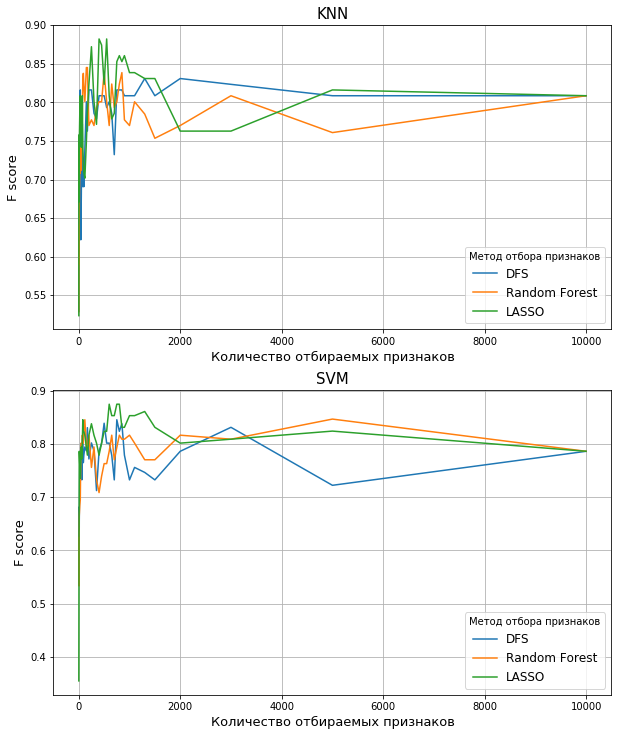

In [15]:
fig = plt.figure(figsize=(10, 12))
fig.tight_layout()
fig.subplots_adjust(top=0.9)

ax1 = fig.add_subplot(211)
ax1.plot(num_selected_features, knn_result['dfs'], label='DFS')
ax1.plot(num_selected_features, knn_result['rf'], label='Random Forest')
ax1.plot(num_selected_features, knn_result['lasso'], label='LASSO')
ax1.set_xlabel('Количество отбираемых признаков', fontsize=13)
ax1.set_ylabel('F score', fontsize=13)
ax1.set_title('KNN', fontsize=15)
ax1.legend(fontsize=12, title='Метод отбора признаков')
ax1.grid()

ax2 = fig.add_subplot(212)
ax2.plot(num_selected_features, svc_result['dfs'], label='DFS')
ax2.plot(num_selected_features, svc_result['rf'], label='Random Forest')
ax2.plot(num_selected_features, svc_result['lasso'], label='LASSO')
ax2.set_xlabel('Количество отбираемых признаков', fontsize=13)
ax2.set_ylabel('F score', fontsize=13)
ax2.set_title('SVM', fontsize=15)
ax2.legend(fontsize=12, title='Метод отбора признаков')
ax2.grid()

plt.savefig('results/merged_results.png')

**Максимальная** точность для каждой модели отбора и финальной модели

In [16]:
from prettytable import PrettyTable

quality_table = PrettyTable()
quality_table.field_names = ['Модель отбора\Финальная модель', 'kNN', 'SVM']

max_knn_dfs = max(knn_result['dfs'])
max_knn_dfs_features = num_selected_features[knn_result['dfs'].index(max_knn_dfs)]

max_knn_rf = max(knn_result['rf'])
max_knn_rf_features = num_selected_features[knn_result['rf'].index(max_knn_rf)]

max_knn_lasso = max(knn_result['lasso'])
max_knn_lasso_features = num_selected_features[knn_result['lasso'].index(max_knn_lasso)]

max_svc_dfs = max(svc_result['dfs'])
max_svc_dfs_features = num_selected_features[svc_result['dfs'].index(max_svc_dfs)]

max_svc_rf = max(svc_result['rf'])
max_svc_rf_features = num_selected_features[svc_result['rf'].index(max_svc_rf)]

max_svc_lasso = max(svc_result['lasso'])
max_svc_lasso_features = num_selected_features[svc_result['lasso'].index(max_svc_lasso)]

quality_table.add_row(['DFS',
               f'score: {max_knn_dfs:.2f}, features: {max_knn_dfs_features}',
               f'score: {max_svc_dfs:.2f}, features: {max_svc_dfs_features}'])

quality_table.add_row(['RF',
               f'score: {max_knn_rf:.2f}, features: {max_knn_rf_features}',
               f'score: {max_svc_rf:.2f}, features: {max_svc_rf_features}'])

quality_table.add_row(['LASSO',
               f'score: {max_knn_lasso:.2f}, features: {max_knn_lasso_features}',
               f'score: {max_svc_lasso:.2f}, features: {max_svc_lasso_features}'])

quality_table.align = 'c'

performance_table = PrettyTable()
performance_table.field_names = ['Модель отбора', 'Время обучения, минут']

performance_table.add_row(['DFS', '55'])
performance_table.add_row(['RF', rf_gs.refit_time_ / 60])
performance_table.add_row(['LASSO', lasso_gs.refit_time_ / 60])

performance_table.align = 'c'
performance_table.float_format = '.4'

print(quality_table)
print(performance_table)

with open('results/quality_table.txt', 'w', encoding='utf8') as quality_table_file:
    quality_table_file.write(quality_table.get_string())
    
with open('results/performance_table.txt', 'w', encoding='utf8') as performance_table_file:
    performance_table_file.write(performance_table.get_string())

+--------------------------------+-----------------------------+-----------------------------+
| Модель отбора\Финальная модель |             kNN             |             SVM             |
+--------------------------------+-----------------------------+-----------------------------+
|              DFS               | score: 0.83, features: 1300 |  score: 0.85, features: 750 |
|               RF               |  score: 0.85, features: 150 | score: 0.85, features: 5000 |
|             LASSO              |  score: 0.88, features: 400 |  score: 0.87, features: 600 |
+--------------------------------+-----------------------------+-----------------------------+
+---------------+-----------------------+
| Модель отбора | Время обучения, минут |
+---------------+-----------------------+
|      DFS      |           55          |
|       RF      |         0.0028        |
|     LASSO     |         0.0028        |
+---------------+-----------------------+


## Выводы

Как видно из таблицы с лучшими результатами **DFS** выбирает признаки таким образом, что итоговый алгоритм покаывает лучшее качество. Это объясняется тем, что исследуемая модель отбора признаков утроена сложнее, чем традиционные и, таким образом, может обучаться сложным нелинейным закономерностям и фильтровать шумовые признаки.

Исследуемая модель имеет на два порядка больше время обучения. Это объясняется отстутствием *GPU* на машине, на которой проводился эксперимент.

Подводя итог вышесказаному, можно сказать, что данный подход имеет преимущества по сравнению с традиционными, а время обучения компенсируется более мощным *CPU* и *GPU*. Если данные имеют высокую размерность, имеют сложную структуру и зашумлены, то данный подход более выгоден по сравнению с традиционными.